In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
import xlwt

## Specify the model to be used
COCO and MPI are body pose estimation model. COCO has 18 points and MPI has 15 points as output.

HAND is hand keypoints estimation model. It has 22 points as output

Ensure that the model files are available in the folders.

In [2]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    # slightly modified for visualization purposes
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [-1,8], [8,9], [9,10], [-1,11], [11,12], [12,13], [14,-1] ]
    

#### Let us load an image with multiple people and check what the model sees

In [3]:
image1 = cv2.imread("multiple.jpeg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]
threshold = 0.1

#### Load the network and pass the image through the network

In [4]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368
inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
H = output.shape[2]
W = output.shape[3]
print(output.shape)

(1, 44, 46, 46)


#### Slice a probability map from the output for a specific keypoint and plot the heatmap ( after resizing ) on the image itself

(-0.5, 1279.5, 1071.5, -0.5)

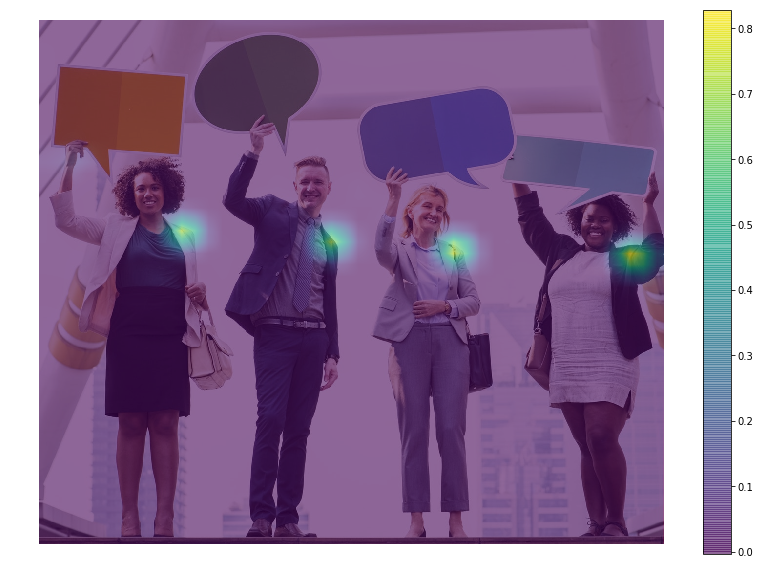

In [5]:
i = 5
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

#### Similarly plot the affinity map on the image

(-0.5, 1279.5, 1071.5, -0.5)

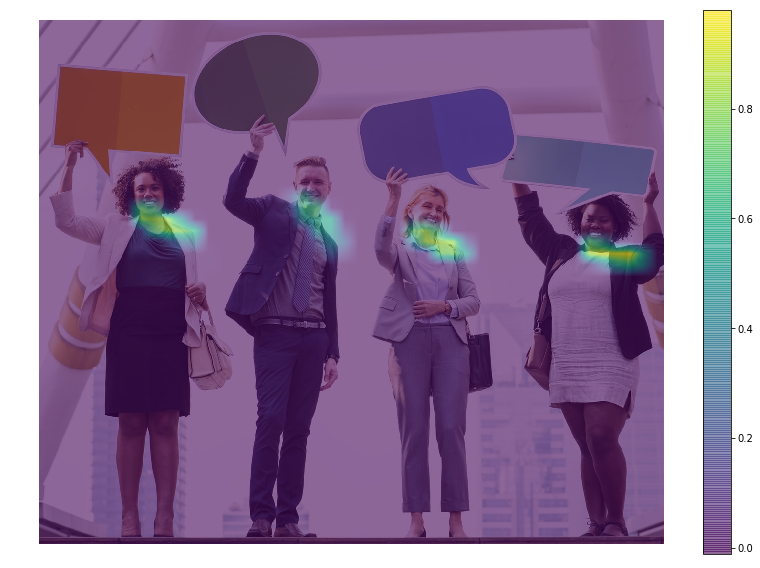

In [6]:
i = 24
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

#### Next, we find the keypoints for a image with only single person

In [7]:
def findSquaredDist(A, B):
    # finds squared distance between two points in 2-D space
    # avoids loss of precision in next function below
    return (A[0]-B[0])**2 + (A[1]-B[1])**2

In [8]:
def findAngleFromSpine(point, A, B):
    # finds angle formed at base and top of spine -> returns larger one - the larger angle carries more risk of injury
    a_2 = findSquaredDist(A, point)
    b_2 = findSquaredDist(point, B)
    c_2 = findSquaredDist(A, B)
    cos_A = (b_2 + c_2 - a_2)/(2*(b_2*c_2)**0.5)
    angle_A = math.acos(cos_A)* 180 / math.pi # for better debugging converting to degrees
    cos_B = (a_2 + c_2 - b_2)/(2*(a_2*c_2)**0.5)
    angle_B = math.acos(cos_B)* 180 / math.pi # for better debugging converting to degrees
    return max(angle_A, angle_B)

In [9]:
### init x and y inputs
x_train_good = []
x_train_bad = []


2
4
4
4
4
6
10


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


11


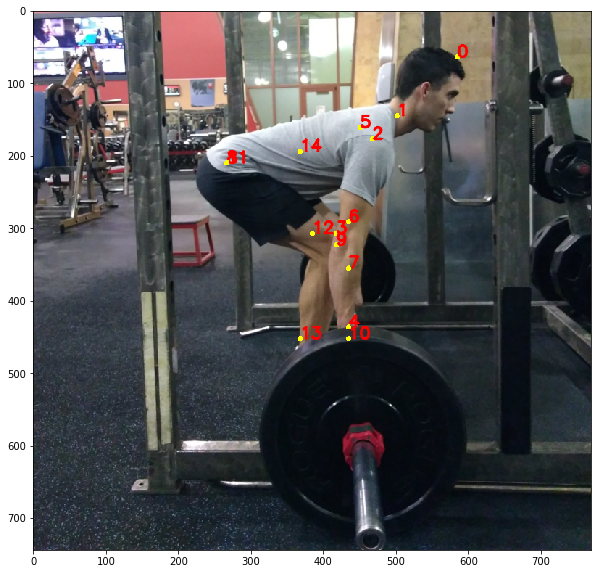

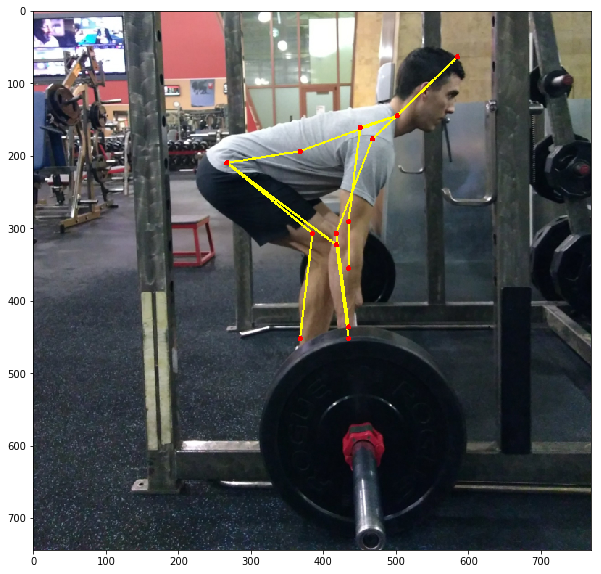

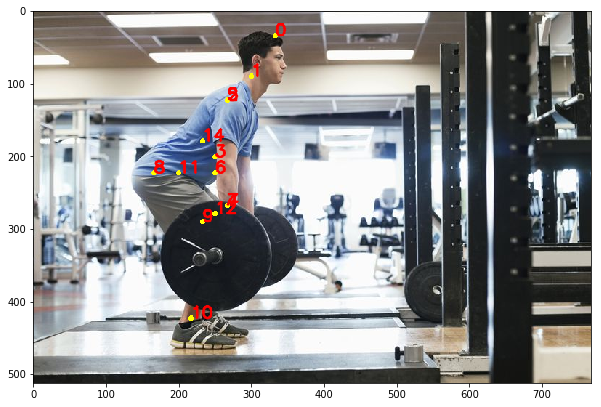

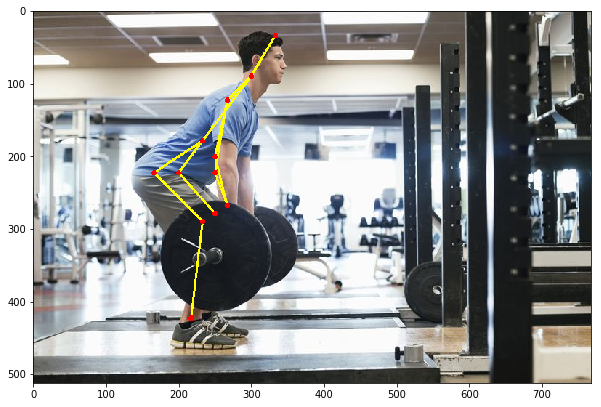

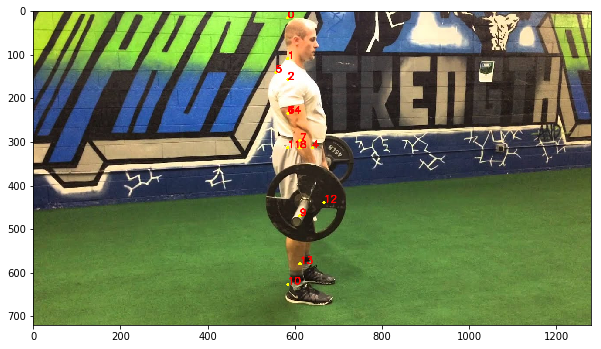

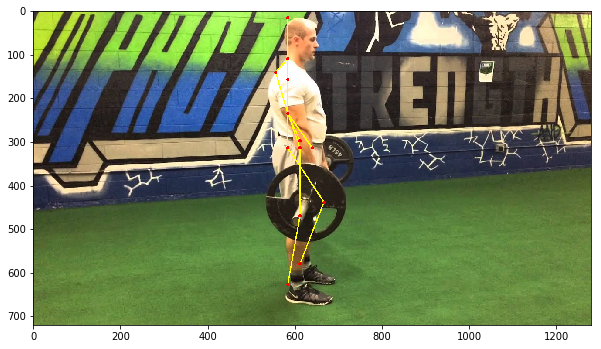

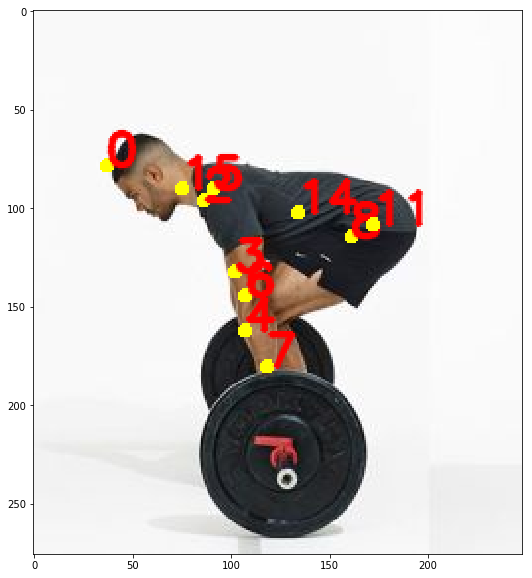

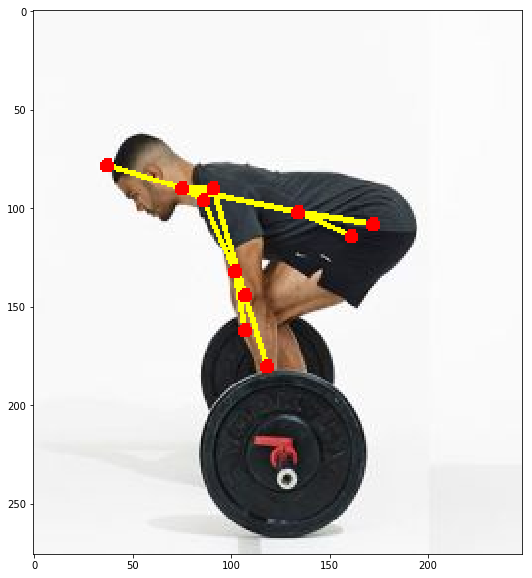

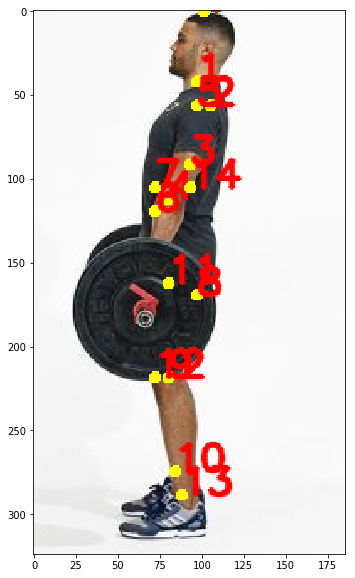

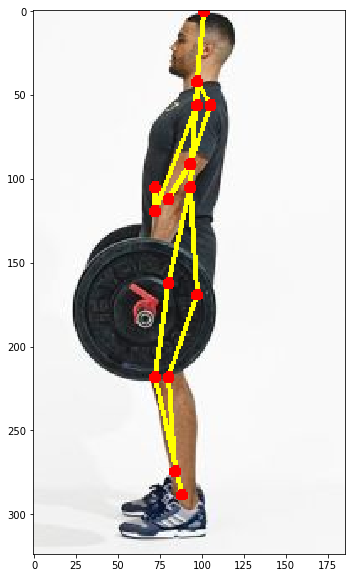

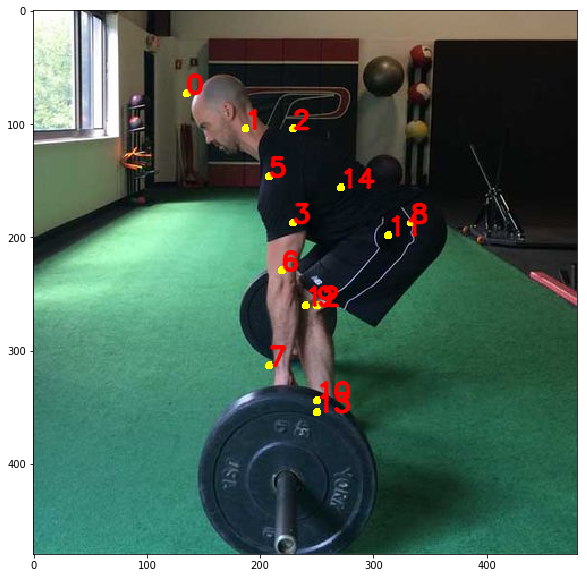

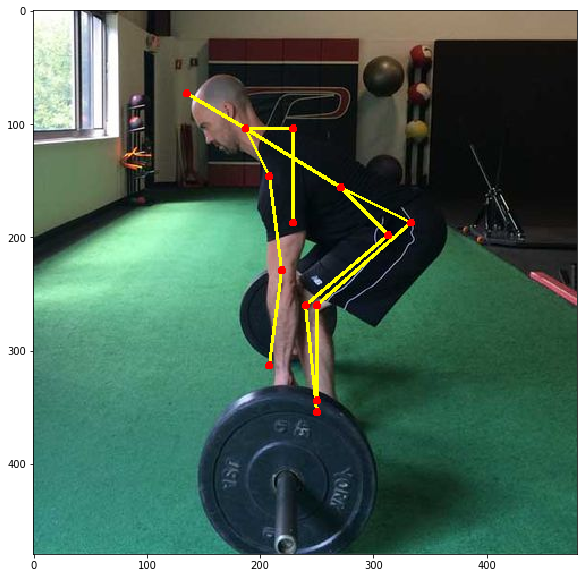

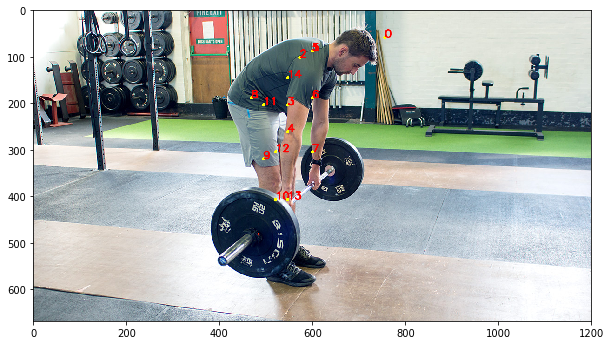

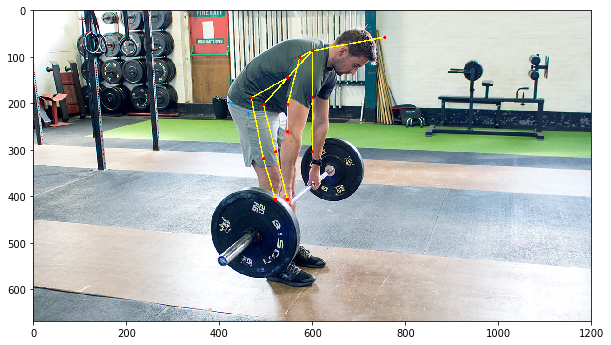

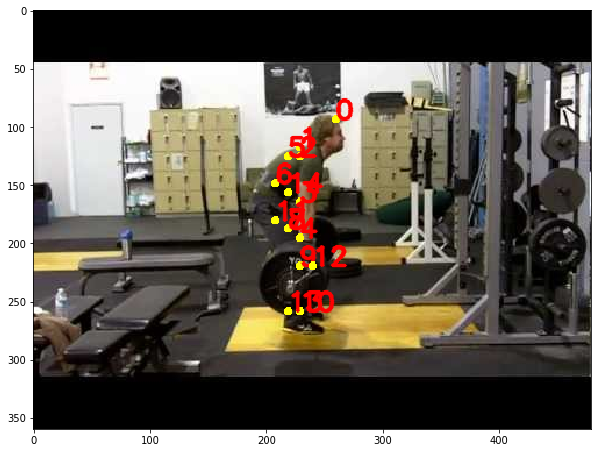

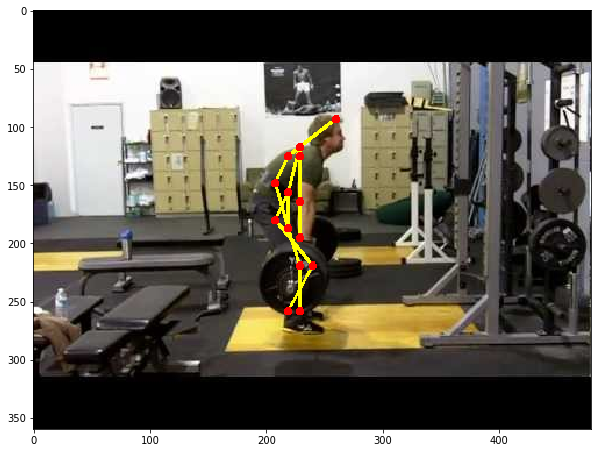

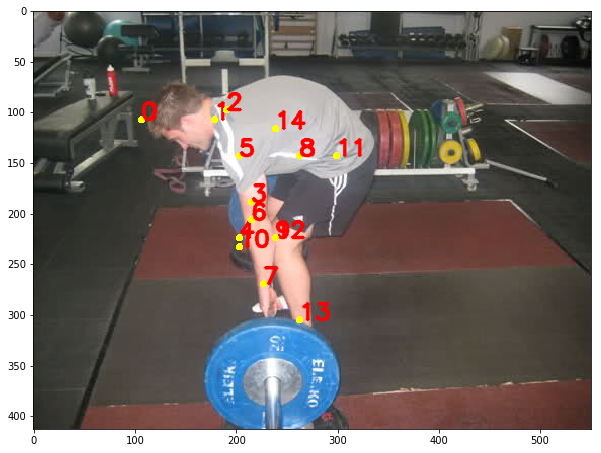

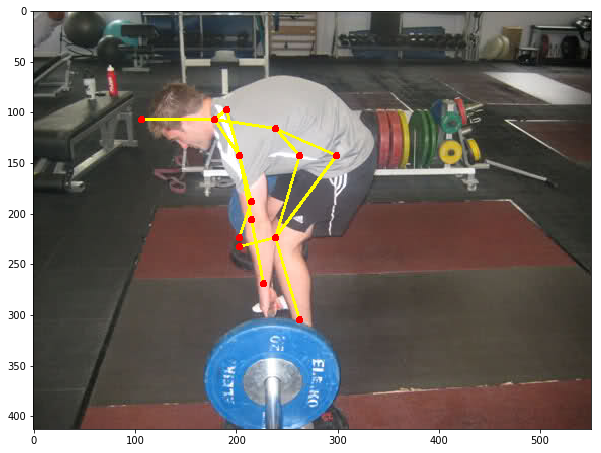

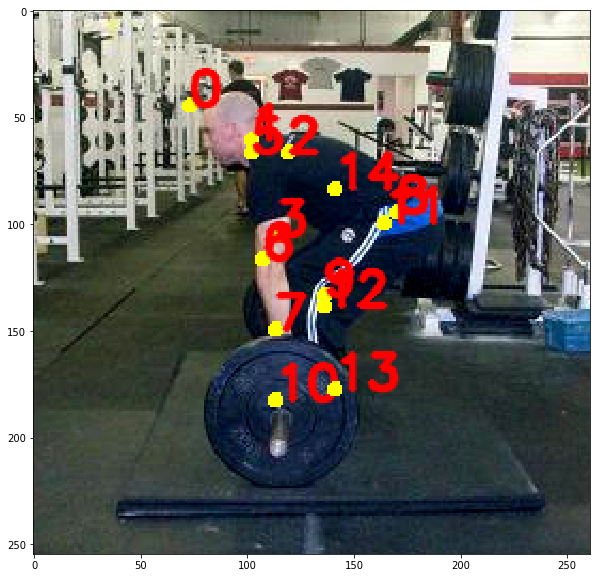

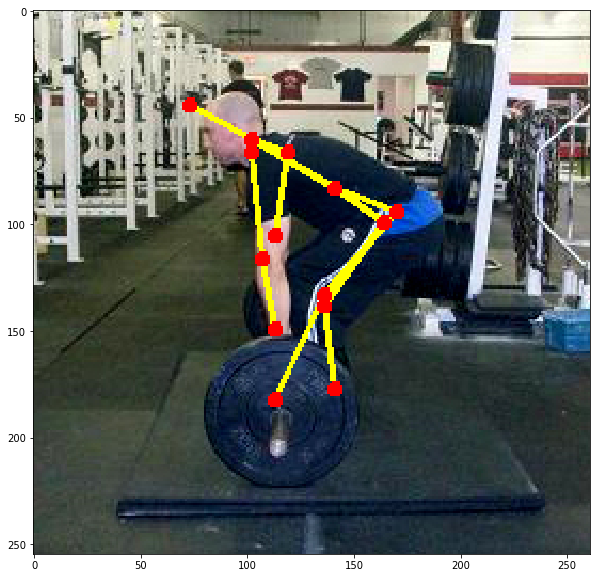

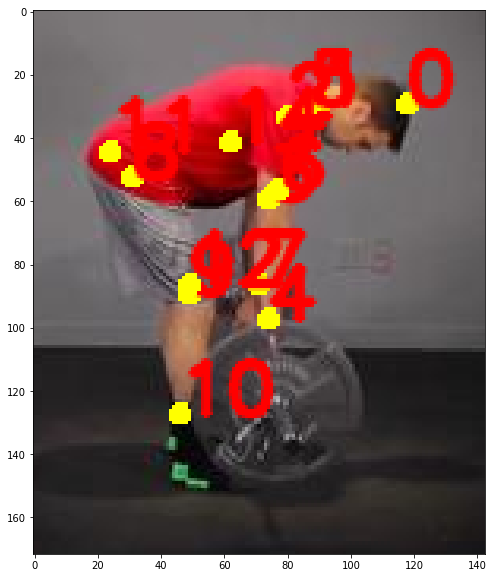

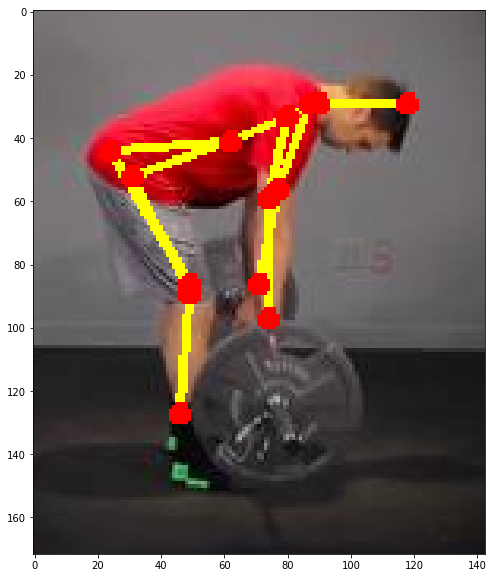

In [12]:
num_good = 6
num_bad = 5

for test_num in range(1,num_good + num_bad + 1):
    if test_num <= num_good:
        label = "good" # good, bad or test
    else:
        label = "bad"
    file_path = label+"/"+str(test_num)+".jpg"
    if label == "bad":
        file_path = label+"/"+str(test_num-num_good)+".jpg"
    frame = cv2.imread(file_path)
    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1

    #### Pass it through the network

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)

    output = net.forward()
    H = output.shape[2]
    W = output.shape[3]

    #### gather the points and plot the keypoints and the skeleton figure

    # Empty list to store the detected keypoints
    points = []

    for i in range(nPoints):
        # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # Scale the point to fit on the original image
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H

        if prob > threshold : 
            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
        else :
            points.append(None)

    ## 2 - BAR DISTANCE
    avg_x_wrists = None
    if points[4] and points[7] and points[10] and points[13] and False: # not running this block for now
        right_forearm_len = findSquaredDist(points[3], points[4])**0.5
        left_forearm_len = findSquaredDist(points[6], points[7])**0.5
        avg_forearm_len = (right_forearm_len + left_forearm_len)/2
        # percentage of forearm length to use since bar should be
        # lifted from midfoot -> using forearm length as estimate for foot length
        bar_x_range_from_foot = avg_forearm_len * 75
        print(avg_forearm_len)

        # estimates bar dist from ankles
        # midpoint of wrists - if picture taken at slight angle
        avg_x_wrists = (points[4][0] + points[7][0])/2
        avg_y_wrists = (points[4][1] + points[7][1])/2
        points.append((int(avg_x_wrists), int(avg_y_wrists)))
        cv2.circle(frameCopy, (int(avg_x_wrists), int(avg_y_wrists)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(17), (int(avg_x_wrists), int(avg_y_wrists)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(avg_x_wrists), int(avg_y_wrists)), 3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # midpoint of ankles - if picture taken at slight angle
        avg_x_ankles = (points[10][0] + points[13][0])/2
        avg_y_ankles = (points[10][1] + points[13][1])/2
        points.append((int(avg_x_ankles), int(avg_y_ankles)))
        cv2.circle(frameCopy, (int(avg_x_ankles), int(avg_y_ankles)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(18), (int(avg_x_ankles), int(avg_y_ankles)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(avg_x_ankles), int(avg_y_ankles)), 3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        dist_bar = abs(avg_x_wrists - avg_x_ankles)
        print(dist_bar)

    ##
    
    if False:

        # midpoint of shoulders
        avg_x = (points[2][0] + points[5][0])/2
        avg_y = (points[2][1] + points[5][1])/2
        points.append((int(avg_x), int(avg_y)))
        cv2.circle(frameCopy, (int(avg_x), int(avg_y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(15), (int(avg_x), int(avg_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(avg_x), int(avg_y)), 3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # midpoint of hips
        avg_x = (points[8][0] + points[11][0])/2
        avg_y = (points[8][1] + points[11][1])/2
        points.append((int(avg_x), int(avg_y)))
        cv2.circle(frameCopy, (int(avg_x), int(avg_y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(16), (int(avg_x), int(avg_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(avg_x), int(avg_y)), 3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        ## 1 - BACK FORM
        # calculates angle from spine for midpoint of shoulders and chest
        shoulders_angle = findAngleFromSpine(points[-2], points[1], points[-1])
        chest_angle = findAngleFromSpine(points[14], points[1], points[-1])
        print("Shoulder Angle from Spinal Baseline: "+str(shoulders_angle)+" degrees")
        print("Chest Angle from Spinal Baseline: "+str(chest_angle)+" degrees")
        spine_threshold = 10 # this can be modified for experimentation
        if max(shoulders_angle, chest_angle) > spine_threshold:
            print("Unsafe back form - keep neutral spine")

        ## 3 - ARM TO SPINAL BASELINE ANGLE
        if avg_x_wrists:
            a_2 = findSquaredDist((avg_x_wrists,avg_y_wrists), points[-2])
            b_2 = findSquaredDist(points[-2], points[-1])
            c_2 = findSquaredDist((avg_x_wrists,avg_y_wrists), points[-1])
            cos_A = (b_2 + c_2 - a_2)/(2*(b_2*c_2)**0.5)
            angle_A = math.acos(cos_A)* 180 / math.pi
            print("Angle formed at shoulder: "+str(angle_A)+" degrees")

    # Draw Skeleton
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 2)
            
    for i in range(len(points)):
        if points[i]:
            x = points[i][0]
            y = points[i][1]
            cv2.circle(frameCopy, (int(x), int(y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            cv2.circle(frame, (int(x), int(y)), 3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

    # spine
    ##cv2.line(frame, points[1], points[-1], (255, 0, 0), 3)

    plt.figure(figsize=[10,10])
    plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
    plt.figure(figsize=[10,10])
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if label == "good":
        temp = []
        for i in points[:15]:
            if i:
                temp.append(i[0])
                temp.append(i[1])
            else:
                temp.append(-1)
                temp.append(-1)
                print(test_num)
        x_train_good.append(temp)
    else:
        temp = []
        for i in points[:15]:
            if i:
                temp.append(i[0])
                temp.append(i[1])
            else:
                temp.append(-1)
                temp.append(-1)
                print(test_num)
        x_train_bad.append(temp)


In [15]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

clf = Ridge(alpha=1.0) #Lasso(alpha=1.0) #LogisticRegression(random_state=1) #ElasticNet(alpha=1.0)

clf.fit(x_train_good+x_train_bad, [1]*len(x_train_good)+[0]*len(x_train_bad))

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
results = clf.predict([
[333, 33, 300, 89, 267, 122, 250, 200, 267, 267, 267, 122, 250, 222, 267, 267, 166, 222, 233, 289, 217, 422, 200, 222, 250, 278, -1, -1, 233, 178]
])
print(sigmoid((results-0.5)*6)) # running through sigmoid to force strict restraint on probabilities

[0.95258941]


In [20]:
inWidth = 368
inHeight = 368
threshold = 0.1


input_source = "e.mp4"
cap = cv2.VideoCapture(input_source)
hasFrame, frame = cap.read()

vid_writer = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 2, (frame.shape[1],frame.shape[0]))

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
counter = 0
while cv2.waitKey(1) < 0:
    t = time.time()
    hasFrame, frame = cap.read()
    frameCopy = np.copy(frame)
    if not hasFrame:
        cv2.waitKey()
        break

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()

    H = output.shape[2]
    W = output.shape[3]
    # Empty list to store the detected keypoints
    points = []

    for i in range(nPoints):
        # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        
        # Scale the point to fit on the original image
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H

        if prob > threshold : 
            cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)

            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
        else :
            points.append(None)

    # Draw Skeleton
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3, lineType=cv2.LINE_AA)
            cv2.circle(frame, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.circle(frame, points[partB], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
    
    temp = []
    for i in points:
        if i:
            temp.append(i[0])
            temp.append(i[1])
        else:
            temp.append(-1)
            temp.append(-1)
    result = clf.predict([temp])
    
    cv2.putText(frame, "Time taken = {:.2f} sec".format(time.time() - t), (50, 50), cv2.FONT_HERSHEY_COMPLEX, .8, (0, 0, 0), 2, lineType=cv2.LINE_AA)
    cv2.putText(frame, "Prediction: " + str(sigmoid((result-0.5)*6)), (50, 100), cv2.FONT_HERSHEY_COMPLEX, .8, (0, 0, 0), 2, lineType=cv2.LINE_AA)

    # cv2.putText(frame, "OpenPose using OpenCV", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 50, 0), 2, lineType=cv2.LINE_AA)
    # cv2.imshow('Output-Keypoints', frameCopy)
    # cv2.imshow('Output-Skeleton', frame)

    print('writing frame '+str(counter))
    vid_writer.write(frame)
    print('wrote frame '+str(counter))
    counter += 1
print('releasing')
vid_writer.release()
print('done')

writing frame 0
wrote frame 0
writing frame 1
wrote frame 1
writing frame 2
wrote frame 2
writing frame 3
wrote frame 3
writing frame 4
wrote frame 4
writing frame 5
wrote frame 5
releasing
done
